# **Classificazione Dati Genetici**

L'obiettivo è quello di analizzare delle immagini che rappresentano delle mutazioni genetiche, alcune casuali, altre frutto della selezione naturale e di distinguere tra le due categorie

In [137]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
import cv2
import os
import re
import random

In [140]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Preprocessing

In [141]:
#Unione delle cartelle immagini e caricamento dataset

os.chdir("/content/drive/My Drive/Progetto DL")

folder =  "./dati_genetici.zip"
images = []
labels = [] #etichette [0, 1] --> 0:neutral, 1:selection

#target_size = (48,1000) #Dimensione delle immagini

def load_images_from_folder_recursive(folder):
    """
    Entra ricorsivamente nelle directory che contengono le immagini dei dataset
    di training e di test, le legge e le aggiunge alla lista delle immagini.
    A ogni immagine viene associata un'etichetta: 0 se l'immagine è neutral,
    1 se è una selection.
    """
    for item_name in os.listdir(folder):
        item_path = os.path.join(folder, item_name)

        if os.path.isdir(item_path):
            print(f"Directory: {item_path}")
            load_images_from_folder_recursive(item_path)
        elif os.path.isfile(item_path):
            #print(f"file: {item_path}")
            if re.search(r"selection", item_path):
                labels.append(1)
            else:
                labels.append(0)
            img = cv2.imread(item_path)
            if img is not None:
            #if img.shape != (1000,48,3):
             #   img = cv2.resize(img, target_size)
              images.append(img)


load_images_from_folder_recursive(folder)


print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")

Directory: ./dati_genetici.zip/NEUTRAL
Directory: ./dati_genetici.zip/NEUTRAL/TEST_IMG
Directory: ./dati_genetici.zip/NEUTRAL/TRAIN_IMG
Directory: ./dati_genetici.zip/SELECTION
Directory: ./dati_genetici.zip/SELECTION/TEST_IMG
Directory: ./dati_genetici.zip/SELECTION/TRAIN_IMG
Loaded 2080 images.
Loaded 2080 labels.


In [142]:
#Eliminazione dell'immagine che ha un formato diverso (1002, 48, 3)

delete_img_index = []
for index,img in enumerate(images):
  if img.shape != (1000,48,3):
    delete_img_index.append(index)

for index in delete_img_index:
  images.pop(index)
  labels.pop(index)

print(f"Loaded {len(images)} images.")
print(f"Loaded {len(labels)} labels.")

Loaded 2079 images.
Loaded 2079 labels.


In [143]:
images[1].shape

(1000, 48, 3)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
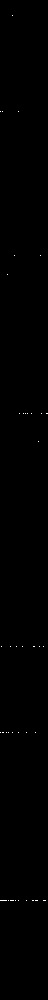

In [144]:
images[1]

In [145]:
#Shuffle delle immagini e delle label (allo stesso modo)
random.seed(42)
shuffled = sorted(zip(images, labels), key=lambda _: random.random())
images, labels = zip(*shuffled)

X, y = np.array(images), np.array(labels)


[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


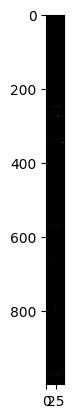

In [146]:
#suddivisione randomica del dataset tra train (70%) e test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#corversione e normalizzazione
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(X_train[444])
plt.imshow(X_train[444]);

# Costruzione CNN

In [147]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization

# Creazione modello

model_1 = Sequential()

# Primo strato convoluzionale:
# - 16 filtri, ciascuno di dimensione 5x5
# - Stride di 2x2 per ridurre le dimensioni dell'immagine
# - Padding 'same' per mantenere la dimensione spaziale
# - input_shape=X_train.shape[1:] indica la forma delle immagini di input
model_1.add(Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=X_train.shape[1:]))

# Funzione di attivazione ReLU per introdurre non-linearità
model_1.add(Activation('relu'))

# Pooling medio per ridurre ulteriormente la dimensione spaziale
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout al 40% per ridurre l'overfitting
model_1.add(Dropout(0.4))

# Secondo strato convoluzionale:
# - 32 filtri, ciascuno di dimensione 3x3
# - Stride di 2x2, padding 'same' per mantenere dimensione compatibile
model_1.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))

# Attivazione ReLU
model_1.add(Activation('relu'))

# Altro strato di pooling medio per ridurre dimensione
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout al 40%
model_1.add(Dropout(0.4))

# Appiattimento della mappa dei canali in un vettore per il fully connected layer
model_1.add(Flatten())

# Strato fully connected (denso) con 128 neuroni
model_1.add(Dense(128))
model_1.add(Activation('relu'))

# Dropout al 50% prima dell’output
model_1.add(Dropout(0.5))

# Strato di output con 1 neurone e attivazione sigmoide per classificazione binaria
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Stampa del riepilogo del modello
model_1.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 500, 24, 16)    │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 500, 24, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 250, 12, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 250, 12, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 125, 6, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 125, 6, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 62, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 5952)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       761,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 767,969 (2.93 MB)

 Trainable params: 767,969 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

In [148]:
print(X_train.shape)
print(X_test.shape)

(1455, 1000, 48, 3)
(624, 1000, 48, 3)


In [149]:
#configurazione e addestramento

#Alg: mini-batch gradient descent
from tensorflow.keras.optimizers import  Adam

batch_size = 32


#Ottimizzatore ADAM con learning rate=0.0005 con weight decay
opt = Adam(learning_rate=0.0005, weight_decay=1e-6)

#Addestramento della rete con loss 'binary_crossentropy', 7 epoche, batch_size 32
model_1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history=model_1.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=7,
              validation_data=(X_test, y_test),
              shuffle=True)

Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5083 - loss: 0.6761 - val_accuracy: 0.6683 - val_loss: 0.6405
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7259 - loss: 0.5910 - val_accuracy: 0.7131 - val_loss: 0.5612
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7798 - loss: 0.4643 - val_accuracy: 0.7901 - val_loss: 0.4745
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8232 - loss: 0.4074 - val_accuracy: 0.7901 - val_loss: 0.4519
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8092 - loss: 0.4041 - val_accuracy: 0.8045 - val_loss: 0.4315
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8450 - loss: 0.3543 - val_accuracy: 0.7885 - val_loss: 0.4225
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8337 - loss: 0.3450 - val_accuracy: 0.8061 - val_loss: 0.4170


In [150]:
#Valutazione del modello
results = model_1.evaluate(X_test, y_test, verbose=0)

print(results)

[0.4170307219028473, 0.8060897588729858]


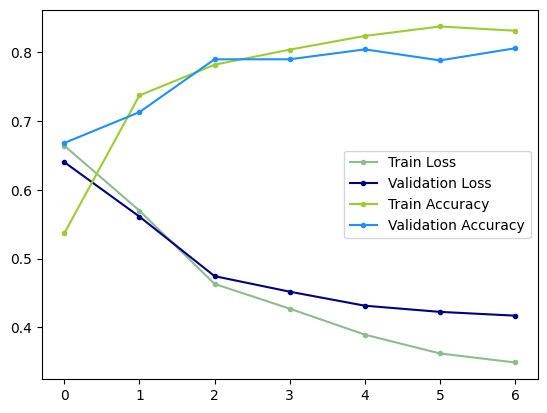

In [151]:
fig, ax = plt.subplots()
ax.plot(history.history["loss"],'darkseagreen', marker='.', label="Train Loss")
ax.plot(history.history["val_loss"],'navy', marker='.', label="Validation Loss")
ax.plot(history.history["accuracy"],'yellowgreen', marker='.', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'dodgerblue', marker='.', label="Validation Accuracy")
ax.legend()

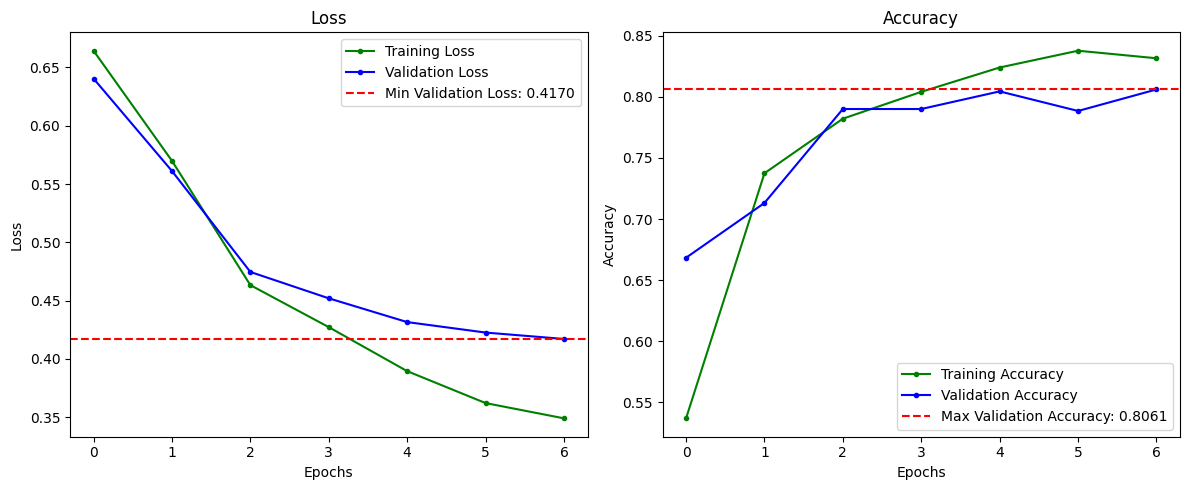

In [152]:
# Plot: andamento training/validation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'g', marker='.',label='Training Loss')
plt.plot(history.history['val_loss'],'b', marker='.', label='Validation Loss')
plt.axhline(min(history.history['val_loss']), color='red', linestyle='--', label=f'Min Validation Loss: {min(history.history["val_loss"]):.4f}')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g', marker='.',label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', marker='.', label='Validation Accuracy')
plt.axhline(max(history.history['val_accuracy']), color='red', linestyle='--', label=f'Max Validation Accuracy: {max(history.history["val_accuracy"]):.4f}')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()